In [1]:
from USG_python import *

In [2]:
# read model parameters
params = Params()

# generate model grid
cells_df, connections = BuildGrid(params)

Grid refinement step no. 1
Grid refinement step no. 2


c:\Users\sjordan\Documents\GitHub\USG_python\USG_python.py:206: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_cells_df = new_cells_df.append(DataFrame(segment_matrix.T, columns=['x', 'y', 'fixed']))
c:\Users\sjordan\Documents\GitHub\USG_python\USG_python.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cells_df = cells_df.append(new_cells_df)


Processed node numbering scheme.
Created Voronoi diagram; computed interfacial areas and connections.
Mapped cell connections.
Processed internal cell geometry.


c:\Users\sjordan\Documents\GitHub\USG_python\USG_python.py:206: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_cells_df = new_cells_df.append(DataFrame(segment_matrix.T, columns=['x', 'y', 'fixed']))
c:\Users\sjordan\Documents\GitHub\USG_python\USG_python.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cells_df = cells_df.append(new_cells_df)
c:\Users\sjordan\Documents\GitHub\USG_python\USG_python.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df.iloc[where(cells_df['quad']==quad_index)]['quad'] += 10.**(-i) * Quadrants(cells_df.iloc[where(cells_df['

`cells_df` contains information about the cells at the first timestep. This includes x and y coordinates, and the following data:
* `b`: aquifer thickness
* `h`: head
* `K`: hydraulic conductivity
* `Ss`: specific storage
* `Q`: extraction (-) or injection (+) rate (volume/time)
* `sum_conduct`: sum of conductance terms associated with the cell
* `vol`: volume of the cell
Plus some additional information that is less relevant to the calculation.

In [4]:
print(cells_df.head())

             x            y     b     h    K       Ss    Q    q  fixed  track  \
0 -1748.546347  1405.473726  10.0  15.0  1.0  0.00005  0.0  0.0    0.0      0   
1  -242.047194   804.448895  10.0  15.0  1.0  0.00005  0.0  0.0    0.0      0   
2  -721.294298  1446.986573  10.0  15.0  1.0  0.00005  0.0  0.0    0.0      0   
3 -1136.376434  1561.447387  10.0  15.0  1.0  0.00005  0.0  0.0    0.0      0   
4 -1681.913661   417.752276  10.0  15.0  1.0  0.00005  0.0  0.0    0.0      0   

   quad  vor_region  sum_conduct     plan_area            vol  
0   0.0          82    65.271029  26832.550068  268325.500685  
1   0.0         364    38.988942  24523.524005  245235.240050  
2   0.0         181    36.029940  28747.954604  287479.546039  
3   0.0          59    37.574684  36426.260491  364262.604912  
4   0.0         384    38.361585  26873.683474  268736.834741  


`connections` contains information about connections, which relate two cells:
* `nodes` = indices of cells on either side of the face; size = (`NConn`, 2)
* `area` = length of the edge that divides the two cells (interfacial area)
* `d` = distance between cells (points that represent the cell)
* `conduct` =  0.5 * `(array(cells_df['K'][self.nodes.T[0]]) + array(cells_df['K'][self.nodes.T[1]])) * self.area/self.d`


In [22]:
print("Number of connections: ", len(connections.area))

print(connections.nodes)
print(connections.nodes.shape)
print(connections.area)
print(connections.d)
print(connections.conduct)

Number of connections:  2149
[[396 157]
 [396 479]
 [396 446]
 ...
 [469 423]
 [423 458]
 [458  27]]
(2149, 2)
[ 6793.57013856 10192.7750231   2961.45951503 ...   587.35137421
   885.56887586   610.01129931]
[625.         625.         601.758081   ... 102.61414292 103.25616792
 101.28346776]
[10.86971222 16.30844004  4.92134565 ...  5.72388325  8.57642593
  6.02281214]


Step through the flow model equation in `USG_python.py`. The first step is to initialize conditions:
* time = 0
* dt = parameter from input file (1.00E-06)

In [6]:
t = 0.
dt = params.dt_init
track_cells = array(where(cells_df['track']==1))[0]             # note the cell numbers for nodes that serve as monitor wells
monitor_well = []
t_monitor = []

Set up left-hand-side of equation set with LHS_Matrix class; diagonal terms will change as the time step changes


In [7]:
implicit = LHS_Matrix(cells_df, connections, params, dt)

In [27]:
print(implicit.col_index)
print(implicit.col_index.shape)
print(implicit.row_index)
print(implicit.row_index.shape)
print(implicit.data)
print(implicit.data.shape)

len(connections.area)*2 + len(cells_df.x)


[  0   1   2 ... 423  27 458]
(5024,)
[  0   1   2 ... 458 458  27]
(5024,)
[ 1.34163109e+07  1.22617834e+07  1.43739971e+07 ... -4.71703426e+00
 -3.31254668e+00 -3.31254668e+00]
(5024,)


5024

The shape of all of these arrays if (5024,), which is equal to:  `NCell + NConn x 2 `
* for `implicit.col_index` and `implicit.row_index`, the first `NCell` terms are just (1, `len(NCell) + 1`). These are the diagonals. 
* The following `NConn x 2` terms are:
    * `implicit.col_index`: node_1, node_2
    * `implicit.row_index`: node_2, node_1


The actual data is also stored in a (5024,) array (`implicit.data`)
* The first `NCell` terms are `cells_df['vol'][i]*cells_df['Ss'][i]/dt + params.gamma*cells_df['sum_conduct'][i]`
* The following `NConn x 2` terms are `data.append(-params.gamma * connections.conduct[i])`, entered twice

In [29]:
# define original values so we can compare differences. 
init_diag = implicit.data

In [28]:
for i in range(3):
    print(i, connections.nodes[i, 0], connections.nodes[i, 1])

0 396 157
1 396 479
2 396 446


Typically, the code would then step through all the timesteps. We will just look at the first timestep to start. 

[ 1.34163109e+07  1.22617834e+07  1.43739971e+07 ... -4.71703426e+00
 -3.31254668e+00 -3.31254668e+00]
[ 1.34163109e+07  1.22617834e+07  1.43739971e+07 ... -4.71703426e+00
 -3.31254668e+00 -3.31254668e+00]


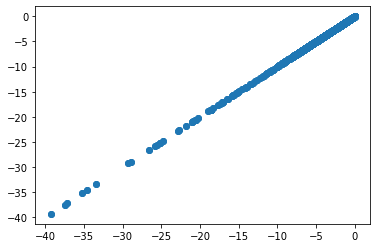

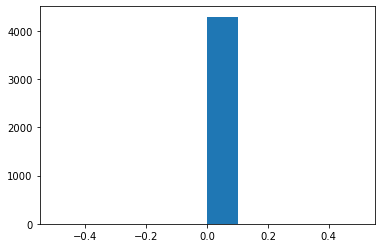

0.0 0.0


In [48]:
t = dt

converged = False

# modify diagonal according to time step size
implicit.Diagonal(cells_df, params, dt)
print(implicit.data)
print(init_diag)

plt.scatter(implicit.data[len(cells_df.x):], init_diag[len(cells_df.x):])
plt.show()
diff = implicit.data[len(cells_df.x):] - init_diag[len(cells_df.x):]
plt.hist(diff)
plt.show()
print(diff.max(), diff.min())

The code then uses the `csr_matrix` function. This turns the sparse matrix in to a **compressed sparse row matrix (CSR)**. MODFLOW-USG uses the CSR format for the **A** matrix. All nonzero coefficients in a row of the matrix are stored sequentially, beginning with the first one in the row and ending with the last. The MODFLOW-USG documentation contains some useful details on how these matrices are defined in their [theoretical documentation](https://pubs.usgs.gov/tm/06/a45/pdf/tm6-A45.pdf), starting on page 32. 

The shape of **A** is `NCELL x NCELL` (aka 726 x 726 for this example). 

In [53]:
    # update sparse equation matrix
    A = csr_matrix( (array(implicit.data),(array(implicit.row_index), array(implicit.col_index))), shape=(len(cells_df), len(cells_df)) )
    print("----------A----------------")
    print(A)
    print("------ Convert to Array------")
    print(A.toarray())
    print(A.shape)



----------A----------------
  (0, 0)	13416310.933292085
  (0, 21)	-1.7142884527902953
  (0, 55)	-8.184834351448561
  (0, 117)	-3.4218845376623372
  (0, 142)	-17.183933237994346
  (0, 170)	-5.39412516359336
  (1, 1)	12261783.446411166
  (1, 18)	-2.5975805102560248
  (1, 95)	-7.753502123036813
  (1, 166)	-4.159644489734506
  (1, 229)	-4.158771833221245
  (1, 337)	-2.1673351130426948
  (1, 348)	-0.6070839024712875
  (2, 2)	14373997.118441846
  (2, 8)	-5.363775820266795
  (2, 26)	-2.682729446373258
  (2, 87)	-3.7329713641488604
  (2, 96)	-1.9708583758763603
  (2, 106)	-2.333160782549807
  (2, 112)	-3.732971364148863
  (3, 3)	18213150.91165867
  (3, 32)	-6.179976837042712
  (3, 46)	-5.440465584100871
  (3, 85)	-2.391703355975599
  (3, 97)	-2.6241742486228925
  :	:
  (722, 575)	-4.854516426378748
  (722, 638)	-5.390390838596868
  (722, 686)	-4.103980479594928
  (722, 722)	7158301.962242127
  (722, 724)	-3.514249654315121
  (723, 554)	-5.5083917417562995
  (723, 555)	-3.1359229048348456
  (72

Now we set up the `b` matrix (the right hand side vector), which has a shape of (`NCell`,)

In [54]:
    # construct explicit vector
    b = RHS_Vector(cells_df, connections)
    print(" +++++++++++ RHS MATRIX +++++++++++++++")
    print(b)
    print(b.shape)

 +++++++++++ RHS MATRIX +++++++++++++++
0     -7.815970e-14
1      0.000000e+00
2      2.131628e-14
3      1.563194e-13
4      1.421085e-14
           ...     
721    0.000000e+00
722    9.947598e-14
723   -1.421085e-14
724   -5.684342e-14
725    1.527667e-13
Length: 726, dtype: float64
(726,)


In [77]:
# print what's going on here
def RHS_Vector(cells_df, connections):
    # construct explicit matrix (run for each time step)
    b = cells_df['Q'] - cells_df['sum_conduct'] * cells_df['h']
    b_start = cells_df['Q'] - cells_df['sum_conduct'] * cells_df['h']

    for i in range(len(connections.nodes)):
        node_1 = connections.nodes[i, 0]
        node_2 = connections.nodes[i, 1]
        b[node_1] += connections.conduct[i] * cells_df['h'][node_2]
        b[node_2] += connections.conduct[i] * cells_df['h'][node_1]
        print(i, node_1, node_2, b[node_1], b[node_2])
        
        # print(i, b)

    return b_start, b

In [78]:
b_start, b = RHS_Vector(cells_df, connections)

0 396 157 -407.64249172620515 -363.210052675403
1 396 479 -163.0158911719025 -511.59502861081626
2 396 446 -89.19570640394275 -695.5634308454232
3 396 368 -67.20146030313164 -712.2867128089098
4 396 526 7.105427357601002e-14 -728.4559153700393
5 495 398 -506.77046614014813 -515.037824176271
6 495 397 0.0 -645.6224103375002
7 696 563 -517.3110792625541 -1021.4047132581268
8 696 725 -509.53420269503823 -1326.1203037134667
9 696 710 -2.2737367544323206e-13 -1149.84628849062
10 142 88 -1066.1736459285687 -1472.347031929214
11 142 15 -1030.4751799012356 -829.67160193443
12 142 117 -891.7946039522801 -444.3056396059461
13 142 173 -521.7123396880032 -642.0150425005282
14 142 0 -53.05961501543021 -510.4127046953061
15 142 170 0.0 -796.8968976997749
16 479 526 -478.2620779877328 -695.1229647469559
17 479 398 -110.8756908394277 -147.65143702796587
18 479 489 -78.23016066853305 -881.5724026476872
19 479 502 -60.71095181305478 -1181.4782043102855
20 479 410 -3.837353157599054 -856.4203425994042
21

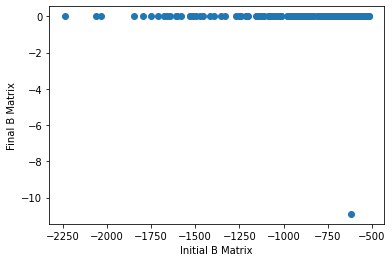

In [82]:
plt.scatter(b_start, b)
plt.ylabel("Final B Matrix")
plt.xlabel("Initial B Matrix")
# plt.ylim(0,0.000001)
# plt.xlim(0,0.000001)
plt.show()

Initial B matrix is calculated from Q, sum of conductances, and h. Then looping through each connection:
* `b[node_1] += connections.conduct[i] * cells_df['h'][node_2]`
* `b[node_2] += connections.conduct[i] * cells_df['h'][node_1]`

From the plot above, you can see that the initial B matrix has a wide range of values, and then the values all go towards 0 (zoom in!):


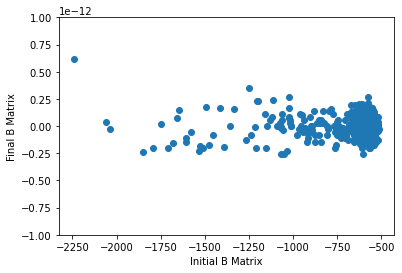

In [95]:
plt.scatter(b_start, b)
plt.ylabel("Final B Matrix")
plt.xlabel("Initial B Matrix")
plt.ylim(-0.000000000001, 0.000000000001)
plt.show()

In [100]:
# solve equations
dh = spsolve(A,b)
print(dh)
print(dh.shape)

[-5.82572370e-21  1.24213979e-26  1.48297524e-21  8.58277305e-21
  1.05759798e-21 -2.26320784e-21  7.57034698e-21 -4.20616564e-21
 -2.99048859e-21 -6.17817035e-21  3.15299349e-21 -5.55474254e-21
 -2.58385134e-21 -1.05329050e-20  1.53947849e-20  5.68434314e-37
 -3.83693108e-36 -2.51251532e-27  4.40553765e-21  2.73641950e-21
 -1.97243909e-20  3.63062778e-21  9.08466016e-29  1.75570064e-20
  9.15978943e-21  6.22479246e-21  1.86398712e-21 -3.13139609e-21
 -2.45145099e-21 -2.67656680e-21  1.21925852e-26  9.47912340e-22
 -4.63678525e-21 -1.15183812e-20  5.47656857e-21 -6.57240031e-21
 -3.93827878e-21 -1.50030876e-26 -6.83576166e-21 -9.25007160e-22
  6.32875044e-21  4.66222378e-21  9.42257681e-21  1.05905855e-20
  2.88101321e-21 -4.61132236e-21 -6.27203200e-21 -2.91418864e-21
 -1.20913885e-20 -1.86469719e-21 -3.90171530e-21  1.78146161e-20
  7.91608681e-21  1.98980976e-20  4.74218523e-21 -2.58969348e-27
  2.89051217e-21 -5.28587883e-21  1.20532967e-21  9.02657012e-21
  1.55137029e-20  1.03564

In [101]:
# determine convergence (all dH must be <= params.dh_max
converged = 1 - sign(sum((abs(dh) > params.dh_max) * 1))

In [102]:
print(converged)

1


In [108]:
sum((abs(dh) > params.dh_max) * 1)

0

In [104]:
dt

1e-06

In [109]:
# update values
t += dt

t_monitor.append(t)
cells_df['h'] += dh

# append to time series data frame
row = []
for monitor in track_cells:
    row.append(cells_df['h'][monitor])
monitor_well.append(row)

# update time step
dt *= params.dt_increase
dt = min(dt, params.dt_max, params.t_end - t)